# Assignment B.5 - Modern face recognition with deep learning

Have you noticed that Facebook has developed an uncanny ability to recognize your friends in your photographs? In the old days, Facebook used to make you to tag your friends in photos by clicking on them and typing in their name. Now as soon as you upload a photo, Facebook tags everyone for you like magic. This technology is called face recognition. Facebook’s algorithms are able to recognize your friends’ faces after they have been tagged only a few times. It’s pretty amazing: these algorithms can recognize faces with 98% accuracy, which is pretty much as good as humans can do!

As a human, your brain is wired to recognize faces automatically and instantly. Computers are not capable of doing this, so you have to teach them how to tackle each step in this process. Specifically, a face recognition system goes through four steps: find faces in the image, analyze their facial features, compare against known faces, and make a prediction of the corresponding persons. Here's described the full pipeline.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/summary.gif" style="height:200px;">

### Table of contents 

In this assignment, you will tackle several problems related to face recognition:
1. **Face detection**. Look at a picture and find all the faces in it. -5
- **Pose estimation**. Understand where the face is turned and correct its pose. 5
- **Face encoding**. Pick up unique features from a face that can be used to distinguish it from others. 5 
- **Face recognition**. Compare the unique features of a face to those of all the people in a database. 5
- **Personal dataset**. Build a custom face recognition dataset. 2

By the end of this notebook, you will have your own face recognition system.

### Required packages

Here are the packages you will need during the assignment.
- [Numpy](http://www.numpy.org)
- [Keras](https://keras.io)
- [OpenCV](https://opencv.org)
- [Dlib](http://dlib.net).

**Note**: In Anaconda Navigator, the package `dlib` can be installed from the **conda-forge** channel. In Google Colab, everything is readily available

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn

%%sysconfig
{
  "python": {
    "args": ["-Xfrozen_modules=off"]
  }
}

C:\Users\yohan\AppData\Roaming\Python\Python311\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\yohan\AppData\Roaming\Python\Python311\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\yohan\AppData\Roaming\Python\Python311\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


UsageError: Line magic function `%%sysconfig` not found.


## 1. Face detection

The first step in your pipeline is face detection. Obviously you need to locate the faces in a photograph before you can try to tell them apart. If you’ve used any camera in the last 10 years, you’ve probably seen face detection in action. Face detection is a great feature for cameras. When the camera can automatically pick out faces, it can make sure that all the faces are in focus before it takes the picture. But you’ll use it for a different purpose:  finding the areas of the image you want to pass on to the next step in your pipeline.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/detection.jpg" style="height:200px;">

### Assignment

Here's what you are required to do for this part of the assignment.

- You are provided with a small dataset of pictures, where each picture contains exactly one face. Extract the faces and their labels (i.e., the person's names). Store them to a new file with the function `dump` in the package `pickle`.


-  Normalize the cropped faces (i.e., divide the pixel values by 255), and split them in train set (70%) and test set (30%) with the function `train_test_split` in the package `sklearn`. 


- Train a small convnet and check its performance on the test set. Remember: don't use the test images for training.


- Try to improve the performance of the baseline convnet by using all the tricks you have learned in the course.

#### Provided functions

Here you will find some useful functions to complete the assignment.

In [3]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
!unzip models.zip

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [4]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [5]:
def extract_faces(image, model="hog"):
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
            
    return faces

In [6]:
def show_grid(faces, figsize=(12,3)):

    n = len(faces)
    cols = 7
    rows = int(np.ceil(n/cols))
    
    fig, ax = plt.subplots(rows,cols, figsize=figsize)

    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if i == n:
                 break
            ax[r,c].imshow(faces[i])
            ax[r,c].axis('off')
            #ax[r,c].set_title('size: ' + str(faces[i].shape[:2]))

In [7]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

#### Hints

The provided function `extract_faces()` applies face detection to a single input image, and returns a list of 128x128 blocks containing the detected faces.

In [8]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/figures.zip
!unzip figures.zip

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [9]:
image = cv2.imread("figures/faces.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

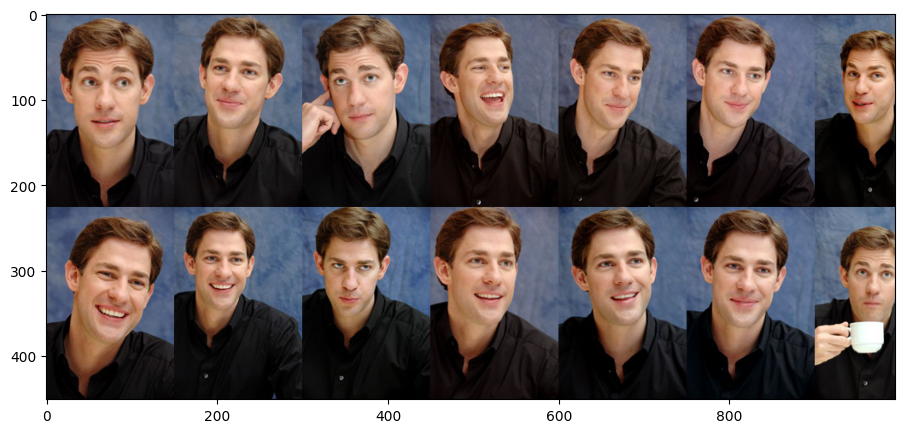

In [10]:
plt.figure(figsize=(15,5))
plt.imshow(image)

In [11]:
faces = extract_faces(image, "cnn")  # Replace 'cnn' with 'hog' for faster but less accurate results

: 

In [ ]:
show_grid(faces)

Moreover, the function `list_images()` locates all the jpeg/png/tiff files in a given folder (including its subfolders).

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/data.zip
!unzip data.zip

In [ ]:
imagePaths = list_images("data")
imagePaths

## 2. Pose estimation

You have isolated the faces in our image. But now you have to deal with the problem that faces turned different directions look totally different to a computer. To account for this, you will try to warp each picture so that the eyes and lips are always in the same place in the image. More concretely, you are going to use an algorithm called face landmark estimation. The basic idea is to locate 68 specific points (called landmarks) that exist on every face:  the top of the chin, the outside edge of each eye, the inner edge of each eyebrow, etc. Then, you’ll simply rotate, scale and shear the image so that the eyes and mouth are centered as best as possible. This will make face recognition more accurate.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/pose.png" style="height:200px;">

### Assignment

Here's what you are required to do for this part of the assignment.

- Further preprocess the face pictures by correcting their pose. You should now have a dataset of cropped, aligned, and normalized faces.


- Re-train your convnets on the modified dataset. 


- Evaluate the performance on the test set, and compare it to the scores obtained with your previously trained convnets.

#### Provided functions

Here you will find some useful functions to complete the assignment.

In [ ]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [ ]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [ ]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [ ]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

#### Hints

The provided function `face_landmarks()` computes the landmarks for a list of cropped faces.

In [ ]:
landmarks = face_landmarks(faces)

In [ ]:
new_faces = []
for (face,shape) in zip(faces, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (int(p[0]),int(p[1])), 1, (0, 0, 255), -1)
    new_faces.append(canvas)

In [ ]:
show_grid(new_faces, figsize=(15,5))

In [ ]:
aligned = align_faces(faces, landmarks)

In [ ]:
show_grid(aligned, figsize=(15,5))

In [ ]:
plt.imshow( np.stack(aligned, axis=3).astype(np.float32).mean(axis=3)/255 )

## 3. Face encoding

The simplest approach to face recognition is to directly classify an unknown face with a convnet trained on your database of tagged people. Seems like a pretty good idea, right? There’s actually a huge problem with that approach. A site like Facebook with billions of users and a trillion photos can’t possibly train such a big convnet. That would take way too long. What you need is a way to extract a few basic measurements from each face, which you can then use to quickly compare the unknown face with your database. For example, you might measure the size of each ear, the spacing between the eyes, the length of the nose, etc. However, it turns out that the measurements that seem obvious to us humans (like eye color) don’t really make sense to a computer looking at individual pixels in an image. Researchers have discovered that the most accurate approach is to let the computer figure out the measurements to collect itself. Deep learning does a better job than humans at figuring out which parts of a face are important to measure.

The solution is to train a convnet. But instead of training the network to classify pictures, it is trained to generate 128 measurements for each face. The training process works by looking at 3 face images at a time: the picture of a known person, another picture of the same known person, and a picture of a totally different person. Then, the algorithm looks at the measurements currently generated for each of those three images. It tweaks the neural network slightly to make sure that the measurements generated for the same person are slightly closer, and the measurements for different persons are slightly further apart. After repeating this step millions of times for millions of images of thousands of different people, the convnet learns to generate 128 measurements for each person. 

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/triplet.png" style="height:400px;">

This process of training a convnet to output face encodings requires a lot of data and computer power. Even with an expensive GPU, it takes about 24 hours of continuous training to get good accuracy. But once the network has been trained, it can generate measurements for any face, even ones it has never seen before! So this step only needs to be done once. Fortunately, the people at [OpenFace](https://cmusatyalab.github.io/openface/) already did this and they published several trained networks which you can directly use. So all you need to do is run your face images through their pre-trained network to get the 128 measurements for each face.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/encoding.png" style="height:300px;">

### Assignment

Here's what you are required to do for this part of the assignment.

- Preprocess the cropped faces by encoding them. You should now have a dataset of cropped and encoded faces.


- Train a neural network on the modified dataset. Since the encoded faces are just 128-length vectors, **you don't need a convnet**. Use a regular neural network with a series of fully-connected layers.


- Evaluate the performance on the test set, and compare it to the scores obtained with your previously trained convnets.

#### Provided functions

In [ ]:
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

#### Hints

The provided function `face_encoder()` computes the encodings for a list of cropped faces. Alignment and normalization are handled internally.

In [ ]:
encoded_faces = face_encoder(faces)

In [ ]:
plt.plot(encoded_faces[0])

## 4. Face recognition

This last step is actually the easiest one in the whole process. All you have to do is find the person in your database of known people who has the closest measurements to some test image. You can do that by using any machine learning classification algorithm, such as neaural network (as you did in the previous section), logistic regression, SVM, nearest neighbours, etc. All you need to do is training a classifier that can take in the measurements from a new test image, and tells which known person is the closest match. Running this classifier must only take milliseconds, so that you can apply it to video sequences.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/test.gif" style="height:300px;">

### Assignment

Here's what you are required to do for this part of the assignment.

-  Train several classifiers (logistic regression, SVM, kNN, neural network) on the dataset of encoded faces (you can use the package `scikit-learn`).

- Evaluate their performance on the test set, in terms of accuracy and speed.

- Finally, run your best classifier on the test images and video available in the `test` folder.

#### Provided functions

In [ ]:
def process_frame(image, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        
        # face classification
        label = "label"
        
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        
    return image

**Note:** cv2.VideoCapture does not work in Google Colab. You can use https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi to capture video 'on the fly' with Google Colab. The following function has to be modified accordingly

In [ ]:
def process_movie(video_name, mode="fast"):
    
    video  = cv2.VideoCapture(video_name)
    
    try:
        
        while True:

            # Grab a single frame of video
            ret, frame = video.read()
            
            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = process_frame(frame, mode)

            # Display the resulting image
            cv2.imshow('Video', image)
    
    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

#### Hints

The provided function `process_frame()` detects and encodes all the faces in the input image.

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/test.zip
!unzip test.zip

In [ ]:
image = cv2.imread("test/example_03.png")

In [ ]:
processed = process_frame(image.copy())
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(processed)

The provided function `process_frame()` detects and encodes the faces in the input video.

In [ ]:
process_movie("test/lunch_scene.mp4")

The special input `0` can be used to access the webcam.

In [ ]:
process_movie(0)

## 5. Build a custom dataset

So far, you have used a pre-curated dataset, where somebody did the hard work of gathering and labeling the images for you. Now, you will tackle the problem of recognizing faces of yourselves, friends, family members, colleagues, etc. To accomplish this, you need to gather examples of faces you want to recognize. You can enroll facial pictures via a webcam attached to your computer.

### Assignment
Here's what you are required to do for this part of the assignment.

- Use your webcam to enroll face pictures of yourself, your friends, etc. To do so, you need to open the webcam, detect faces in the video stream, and save the captured face images to disk. 


- Build a dataset of reasonable size: a group of 10-15 people with 50-100 face pictures each, taken in different conditions of light, angle, emotion, etc.


- Apply the previously developed pipeline to build your own personalized face recognition system.

---
## Credits

This assignment is based on Adam Geitgey's [post](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78).

---